In [25]:
import sys
import os
import gc
import warnings
import random
from copy import deepcopy
import random
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
from madgrad import MADGRAD, MirrorMADGRAD
from torch.optim import AdamW
from transformers import (
    get_constant_schedule,
    get_constant_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
    get_cosine_with_hard_restarts_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    get_polynomial_decay_schedule_with_warmup
)
from torchmetrics import F1Score
from PIL import Image
from sklearn.model_selection import StratifiedKFold, KFold
    
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
tqdm.pandas()

# EDA

In [2]:
classes = ['Red', 'Green', 'Violet', 'White', 'Yellow', 'Brown', 'Black', 'Blue', 'Cyan', 'Grey', 'Orange']
counts = []
for class_name in classes:
    counts.append(len(os.listdir(f"data/train/{class_name}")))

In [3]:
counts

[526, 269, 163, 411, 440, 150, 402, 284, 267, 333, 557]

<BarContainer object of 11 artists>

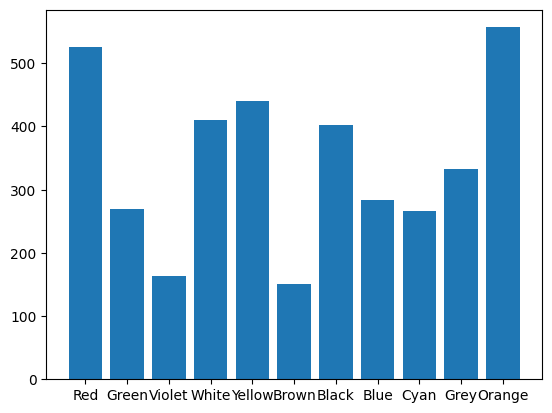

In [4]:
plt.bar(classes, counts)

# Dataset

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transforms=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(256,256)),
    torchvision.transforms.Lambda(lambda a: a / 255),
#     torchvision.transforms.Normalize(mean, std)
])

In [6]:
train_dataset = torchvision.datasets.ImageFolder("data/train", transform=transforms)

In [7]:
train_dataset.classes

['Black',
 'Blue',
 'Brown',
 'Cyan',
 'Green',
 'Grey',
 'Orange',
 'Red',
 'Violet',
 'White',
 'Yellow']

# Losses

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, weight, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()


class ArcFaceLoss(nn.Module):
    def __init__(self, s=45.0, m=0.1, crit="bce", weight=None, reduction="mean",
                 focal_loss_gamma=0, class_weights_norm="batch"):
        super().__init__()

        self.weight = weight
        self.reduction = reduction
        self.class_weights_norm = class_weights_norm
        
        if crit == "focal":
            self.crit = FocalLoss(gamma=focal_loss_gamma)
        elif crit == "bce":
            self.crit = nn.CrossEntropyLoss(reduction="none")   

        if s is None:
            self.s = torch.nn.Parameter(torch.tensor([45.], requires_grad=True, device='cuda'))
        else:
            self.s = s

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        
    def forward(self, logits, labels):

        logits = logits.float()
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        
        labels2 = torch.zeros_like(cosine)
        labels2.scatter_(1, labels.view(-1, 1).long(), 1)
        labels2 *= (1 - 0.1)
        labels2 += 0.005
        output = (labels2 * phi) + ((1.0 - labels2) * cosine)

        s = self.s

        output = output * s
        loss = self.crit(output, labels)

        if self.weight is not None:
            w = self.weight[labels].to(logits.device)

            loss = loss * w
            if self.class_weights_norm == "batch":
                loss = loss.sum() / w.sum()
            if self.class_weights_norm == "global":
                loss = loss.mean()
            else:
                loss = loss.mean()
            
            return loss
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss

# Modules

In [9]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        return cosine

# Model

In [10]:
class ResNet(nn.Module):
    def __init__(self, backbone, output_dim):
        super().__init__()
        self.backbone = backbone
        del backbone.fc
        self.backbone.dropout = nn.Dropout(p=0.1)
        self.backbone.fc = torch.nn.Linear(in_features=2048, out_features=output_dim, bias=True)
        
    def forward(self, image):
        out = self.backbone(image)
#         out = self.out(x)
        return out

In [11]:
class EfficentNet(nn.Module):
    def __init__(self, backbone, output_dim):
        super().__init__()
        self.backbone = backbone
        self.backbone.classifier[0] = nn.Dropout(p=0.1, inplace=True)
        self.backbone.classifier[1] = torch.nn.Linear(in_features=1536, out_features=output_dim, bias=True)
        
    def forward(self, image):
        out = self.backbone(image)
#         out = self.out(x)
        return out

# Loops

In [33]:
def train_epoch(model, data_loader, loss_function, optimizer, scheduler, device):
    model.to(device)
    model.train()
    total_train_loss = 0
    
    f1 = F1Score(num_classes=11, average='macro').to(device)

    dl_size = len(data_loader)
    
    preds = []
    targets = []

    batch_i = 0

    for batch in tqdm(data_loader):
        image, target = batch
        image = image.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()        
        logits = model(image)
        
        preds.append(logits.argmax(dim=1))
        targets.append(target)
                
        loss = loss_function(logits, target)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)
    acc = (targets == preds).sum() / preds.shape[0]
    f1_score = f1(preds, targets)
    
    metrics = {
        "Train Loss": total_train_loss / dl_size,
        "Train Accuracy": acc.item(),
        "Train F1": f1_score.item()
    }
    
    
    return metrics
    
    
def eval_epoch(model, data_loader, loss_function, device):
    model.to(device)
    model.eval()
    total_train_loss = 0
    
    f1 = F1Score(num_classes=11, average='macro').to(device)
    
    preds = []
    targets = []

    dl_size = len(data_loader)

    
    for batch in tqdm(data_loader):
        image, target = batch
        image = image.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            logits = model(image)
            preds.append(logits.argmax(dim=1))
            targets.append(target)
        
        loss = loss_function(logits, target)
        total_train_loss += loss.item()
    
    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)
    acc = (targets == preds).sum() / preds.shape[0]
    f1_score = f1(preds, targets)
    
    metrics = {
        "Eval Loss": total_train_loss / dl_size,
        "Eval Accuracy": acc.item(),
        "Eval F1": f1_score.item()
    }
    
    return metrics

In [45]:
def cross_validation(project_name,
                     model, 
                     dataset, 
                     loss_function, 
                     strat_array=None,
                     device=torch.device("cuda"),
                     random_state: int=69, 
                     shuffle: bool=True, 
                     n_folds: int=4, 
                     epochs: int=5, 
                     lr: float=1e-6,
                     start_fold: int=0, 
                     batch_size: int=32,
                     iters_to_accumulate=None):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    loss_function.to(device)
    if strat_array:
        kfold = StratifiedKFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset, strat_array)
    else: 
        kfold = KFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset)

    for fold, (train_ids, eval_ids) in enumerate(split):
        if fold >= start_fold:
            print(f'FOLD {fold}')
            print('--------------------------------')
            
            for p in model.parameters():
                if p.dim() > 1:
                    nn.init.xavier_uniform_(p)
                else:
                    nn.init.normal_(p)
                    
            optimizer = torch.optim.AdamW(
                model.parameters(),
                lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
            )
            
            train_subsampler = torch.utils.data.Subset(dataset,  train_ids)
            train_loader = torch.utils.data.DataLoader(
                          train_subsampler, 
                          batch_size=batch_size,
                          shuffle=shuffle)

            eval_subsampler = torch.utils.data.Subset(dataset,  eval_ids)
            eval_loader = torch.utils.data.DataLoader(
                          eval_subsampler,
                          batch_size=batch_size,
                          shuffle=shuffle)
            
            total_steps = len(train_loader) * epochs 

            scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)

            mrrs = []

            for epoch_i in range(0, epochs):
                train_metrics = train_epoch(model, train_loader, loss_function, optimizer, scheduler, device)
                eval_metrics = eval_epoch(model, eval_loader, loss_function, device)
                
                print(f"EPOCH: {epoch_i}")
                print(train_metrics)
                print(eval_metrics)


def single_model(model, 
                     dataset, 
                     loss_function, 
                     device=torch.device("cuda"),
                     random_state: int=69, 
                     shuffle=True,
                     epochs: int=15, 
                     lr: float=1e-6,
                     batch_size: int=32,
                     start_epoch=0
                     ):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    loss_function.to(device)
    model.to(device)

    optimizer = MADGRAD(
        model.parameters(),
        lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
    )

    data_loader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=batch_size,
                    shuffle=shuffle
    )
    
    total_steps = len(data_loader) * epochs 

    scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

    for epoch_i in range(0, epochs):
        if epoch_i >= start_epoch:
            train_metrics = train_epoch(model, data_loader, loss_function, optimizer, scheduler, device)
            print("EPOCH", epoch_i)
            print(train_metrics)
            # eval_epoch(fold_model, eval_loader, loss_function, device)

# Cross Validation

In [46]:
!nvidia-smi

Thu Nov 17 09:32:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Graphics...  On   | 00000000:05:00.0 Off |                  Off |
| 30%   44C    P8    35W / 450W |   8144MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [47]:
strat_array = []
target_class = 0
for folder in os.listdir("data/train"):
    for _ in range(len(os.listdir("data/train" + f'/{folder}'))):
        strat_array.append(target_class)
    target_class += 1

In [48]:
n = len(strat_array)
weights = []
for i in range(11):
    weights.append((strat_array.count(i) / n))
    
correct_weights = []
for i in range(11):
    correct_weights.append(weights[i] / sum(weights))

In [ ]:
backbone = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model_weights = torch.load('/content/model/model.pt', map_location=torch.device('cpu'))
backbone = torchvision.models.resnet50(weights=model_weights)
model = ResNet(backbone, 11)

In [49]:
model_back_ef_03 = torchvision.models.efficientnet_b3(weights='IMAGENET1K_V1')
model_ef_03 = EfficentNet(model_back_ef_03, 11)

In [50]:
loss_function = FocalLoss(weight=torch.tensor(correct_weights))

In [32]:
cross_validation(project_name="car_classification",
                     model=model_ef_03, 
                     dataset=train_dataset,
                     strat_array=strat_array,
                     loss_function=loss_function, 
                     device=torch.device("cuda"),
                     random_state=69, 
                     n_folds=4, 
                     epochs=15, 
                     lr=1e-4,
                     start_fold=0, 
                     batch_size=32)

FOLD 0
--------------------------------




  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 1/357 [00:00<03:28,  1.70it/s]

  1%|          | 3/357 [00:00<01:10,  5.01it/s]

  1%|▏         | 5/357 [00:00<00:45,  7.75it/s]

  2%|▏         | 7/357 [00:00<00:35,  9.92it/s]

  3%|▎         | 9/357 [00:01<00:30, 11.36it/s]

  3%|▎         | 11/357 [00:01<00:28, 12.11it/s]

  4%|▎         | 13/357 [00:01<00:27, 12.63it/s]

  4%|▍         | 15/357 [00:01<00:26, 12.99it/s]

  5%|▍         | 17/357 [00:01<00:25, 13.23it/s]

  5%|▌         | 19/357 [00:01<00:25, 13.40it/s]

  6%|▌         | 21/357 [00:01<00:24, 13.52it/s]

  6%|▋         | 23/357 [00:02<00:24, 13.61it/s]

  7%|▋         | 25/357 [00:02<00:24, 13.70it/s]

  8%|▊         | 27/357 [00:02<00:24, 13.66it/s]

  8%|▊         | 29/357 [00:02<00:23, 13.72it/s]

  9%|▊         | 31/357 [00:02<00:23, 13.77it/s]

  9%|▉         | 33/357 [00:02<00:23, 13.81it/s]

 10%|▉         | 35/357 [00:02<00:23, 13.81it/s]

 10%|█         | 37/357 [00:03<00:23, 13.82it/s]

 11%|█      

EPOCH: 0
{'Train Loss': 2.0966277130845548, 'Train Accuracy': 0.2402665764093399, 'Train F1': 0.16684448719024658}
{'Eval Loss': 1.5426479382675236, 'Eval Accuracy': 0.43533119559288025, 'Eval F1': 0.30045780539512634}




  0%|          | 0/357 [00:00<?, ?it/s]

  1%|          | 2/357 [00:00<00:22, 16.06it/s]

  1%|          | 4/357 [00:00<00:23, 15.32it/s]

  2%|▏         | 6/357 [00:00<00:22, 15.30it/s]

  2%|▏         | 8/357 [00:00<00:23, 14.83it/s]

  3%|▎         | 10/357 [00:00<00:24, 14.42it/s]

  3%|▎         | 12/357 [00:00<00:24, 14.22it/s]

  4%|▍         | 14/357 [00:00<00:24, 14.07it/s]

  4%|▍         | 16/357 [00:01<00:24, 14.02it/s]

  5%|▌         | 18/357 [00:01<00:24, 13.95it/s]

  6%|▌         | 20/357 [00:01<00:24, 13.89it/s]

  6%|▌         | 22/357 [00:01<00:24, 13.86it/s]

  7%|▋         | 24/357 [00:01<00:24, 13.87it/s]

  7%|▋         | 26/357 [00:01<00:23, 13.84it/s]

  8%|▊         | 28/357 [00:01<00:23, 13.87it/s]

  8%|▊         | 30/357 [00:02<00:23, 13.87it/s]

  9%|▉         | 32/357 [00:02<00:23, 13.83it/s]

 10%|▉         | 34/357 [00:02<00:23, 13.86it/s]

 10%|█         | 36/357 [00:02<00:23, 13.68it/s]

 11%|█         | 38/357 [00:02<00:23, 13.69it/s]

 11%|█     

EPOCH: 1
{'Train Loss': 1.452069181437586, 'Train Accuracy': 0.46054017543792725, 'Train F1': 0.3726488947868347}
{'Eval Loss': 0.907291609386937, 'Eval Accuracy': 0.6424815654754639, 'Eval F1': 0.5316451191902161}




  0%|          | 0/357 [00:00<?, ?it/s]

  1%|          | 2/357 [00:00<00:22, 15.77it/s]

  1%|          | 4/357 [00:00<00:23, 15.05it/s]

  2%|▏         | 6/357 [00:00<00:24, 14.39it/s]

  2%|▏         | 8/357 [00:00<00:24, 14.07it/s]

  3%|▎         | 10/357 [00:00<00:24, 13.92it/s]

  3%|▎         | 12/357 [00:00<00:24, 13.82it/s]

  4%|▍         | 14/357 [00:00<00:24, 13.74it/s]

  4%|▍         | 16/357 [00:01<00:24, 13.64it/s]

  5%|▌         | 18/357 [00:01<00:24, 13.65it/s]

  6%|▌         | 20/357 [00:01<00:25, 13.36it/s]

  6%|▌         | 22/357 [00:01<00:25, 13.27it/s]

  7%|▋         | 24/357 [00:01<00:24, 13.35it/s]

  7%|▋         | 26/357 [00:01<00:24, 13.46it/s]

  8%|▊         | 28/357 [00:02<00:24, 13.51it/s]

  8%|▊         | 30/357 [00:02<00:23, 13.75it/s]

  9%|▉         | 32/357 [00:02<00:23, 13.74it/s]

 10%|▉         | 34/357 [00:02<00:23, 13.54it/s]

 10%|█         | 36/357 [00:02<00:23, 13.91it/s]

 11%|█         | 38/357 [00:02<00:22, 13.89it/s]

 11%|█     

EPOCH: 2
{'Train Loss': 1.0603527214054633, 'Train Accuracy': 0.6054016351699829, 'Train F1': 0.5234807133674622}
{'Eval Loss': 1.7471352433707534, 'Eval Accuracy': 0.4847528636455536, 'Eval F1': 0.36695700883865356}




  0%|          | 0/357 [00:00<?, ?it/s]

  1%|          | 2/357 [00:00<00:23, 14.95it/s]

  1%|          | 4/357 [00:00<00:24, 14.30it/s]

  2%|▏         | 6/357 [00:00<00:24, 14.12it/s]

  2%|▏         | 8/357 [00:00<00:24, 13.97it/s]

  3%|▎         | 10/357 [00:00<00:24, 13.89it/s]

  3%|▎         | 12/357 [00:00<00:24, 13.84it/s]

  4%|▍         | 14/357 [00:01<00:24, 13.77it/s]

  4%|▍         | 16/357 [00:01<00:24, 13.71it/s]

  5%|▌         | 18/357 [00:01<00:24, 13.58it/s]

  6%|▌         | 20/357 [00:01<00:24, 13.75it/s]

  6%|▌         | 22/357 [00:01<00:24, 13.92it/s]

  7%|▋         | 24/357 [00:01<00:23, 14.05it/s]

  7%|▋         | 26/357 [00:01<00:23, 14.12it/s]

  8%|▊         | 28/357 [00:02<00:23, 14.20it/s]

  8%|▊         | 30/357 [00:02<00:22, 14.23it/s]

  9%|▉         | 32/357 [00:02<00:22, 14.25it/s]

 10%|▉         | 34/357 [00:02<00:22, 14.30it/s]

 10%|█         | 36/357 [00:02<00:22, 14.30it/s]

 11%|█         | 38/357 [00:02<00:22, 14.32it/s]

 11%|█     

EPOCH: 3
{'Train Loss': 0.7976039847990378, 'Train Accuracy': 0.696597695350647, 'Train F1': 0.6383472681045532}
{'Eval Loss': 2.0574068810258592, 'Eval Accuracy': 0.531019926071167, 'Eval F1': 0.4352835416793823}




  0%|          | 0/357 [00:00<?, ?it/s]

  1%|          | 2/357 [00:00<00:23, 15.25it/s]

  1%|          | 4/357 [00:00<00:23, 14.73it/s]

  2%|▏         | 6/357 [00:00<00:24, 14.46it/s]

  2%|▏         | 8/357 [00:00<00:24, 14.33it/s]

  3%|▎         | 10/357 [00:00<00:24, 14.18it/s]

  3%|▎         | 12/357 [00:00<00:24, 14.14it/s]

  4%|▍         | 14/357 [00:00<00:24, 14.11it/s]

  4%|▍         | 16/357 [00:01<00:24, 14.05it/s]

  5%|▌         | 18/357 [00:01<00:24, 14.04it/s]

  6%|▌         | 20/357 [00:01<00:23, 14.08it/s]

  6%|▌         | 22/357 [00:01<00:23, 14.06it/s]

  7%|▋         | 24/357 [00:01<00:23, 14.06it/s]

  7%|▋         | 26/357 [00:01<00:23, 14.06it/s]

  8%|▊         | 28/357 [00:01<00:23, 14.10it/s]

  8%|▊         | 30/357 [00:02<00:23, 14.08it/s]

  9%|▉         | 32/357 [00:02<00:23, 14.05it/s]

 10%|▉         | 34/357 [00:02<00:23, 14.04it/s]

 10%|█         | 36/357 [00:02<00:22, 14.07it/s]

 11%|█         | 38/357 [00:02<00:22, 14.08it/s]

 11%|█     

EPOCH: 4
{'Train Loss': 0.6888668132158053, 'Train Accuracy': 0.7383374571800232, 'Train F1': 0.6858952641487122}
{'Eval Loss': 0.4086432703575041, 'Eval Accuracy': 0.8401681780815125, 'Eval F1': 0.7842687964439392}




  0%|          | 0/357 [00:00<?, ?it/s]

  1%|          | 2/357 [00:00<00:22, 15.81it/s]

  1%|          | 4/357 [00:00<00:22, 15.90it/s]

  2%|▏         | 6/357 [00:00<00:22, 15.36it/s]

  2%|▏         | 8/357 [00:00<00:23, 14.94it/s]

  3%|▎         | 10/357 [00:00<00:23, 14.59it/s]

  3%|▎         | 12/357 [00:00<00:24, 14.36it/s]

  4%|▍         | 14/357 [00:00<00:24, 14.20it/s]

  4%|▍         | 16/357 [00:01<00:24, 14.12it/s]

  5%|▌         | 18/357 [00:01<00:24, 14.07it/s]

  6%|▌         | 20/357 [00:01<00:24, 14.01it/s]

  6%|▌         | 22/357 [00:01<00:23, 14.02it/s]

  7%|▋         | 24/357 [00:01<00:23, 14.06it/s]

  7%|▋         | 26/357 [00:01<00:23, 14.05it/s]

  8%|▊         | 28/357 [00:01<00:23, 14.01it/s]

  8%|▊         | 30/357 [00:02<00:23, 13.99it/s]

  9%|▉         | 32/357 [00:02<00:23, 13.96it/s]

 10%|▉         | 34/357 [00:02<00:23, 13.94it/s]

 10%|█         | 36/357 [00:02<00:23, 13.93it/s]

 11%|█         | 38/357 [00:02<00:22, 13.93it/s]

 11%|█     

EPOCH: 5
{'Train Loss': 0.616185346780037, 'Train Accuracy': 0.7730621099472046, 'Train F1': 0.7234099507331848}
{'Eval Loss': 0.6170905509165355, 'Eval Accuracy': 0.7939010858535767, 'Eval F1': 0.7410974502563477}




  0%|          | 0/357 [00:00<?, ?it/s]

  1%|          | 2/357 [00:00<00:22, 15.94it/s]

  1%|          | 4/357 [00:00<00:22, 15.60it/s]

  2%|▏         | 6/357 [00:00<00:22, 15.30it/s]

  2%|▏         | 8/357 [00:00<00:22, 15.21it/s]

  3%|▎         | 10/357 [00:00<00:22, 15.15it/s]

  3%|▎         | 12/357 [00:00<00:22, 15.16it/s]

  4%|▍         | 14/357 [00:00<00:22, 15.15it/s]

  4%|▍         | 16/357 [00:01<00:22, 15.16it/s]

  5%|▌         | 18/357 [00:01<00:22, 15.09it/s]

  6%|▌         | 20/357 [00:01<00:22, 15.05it/s]

  6%|▌         | 22/357 [00:01<00:22, 15.08it/s]

  7%|▋         | 24/357 [00:01<00:22, 15.10it/s]

  7%|▋         | 26/357 [00:01<00:21, 15.11it/s]

  8%|▊         | 28/357 [00:01<00:21, 15.12it/s]

  8%|▊         | 30/357 [00:01<00:21, 15.12it/s]

  9%|▉         | 32/357 [00:02<00:21, 15.08it/s]

 10%|▉         | 34/357 [00:02<00:21, 15.06it/s]

 10%|█         | 36/357 [00:02<00:21, 14.99it/s]

 11%|█         | 38/357 [00:02<00:21, 14.98it/s]

 11%|█     

EPOCH: 6
{'Train Loss': 0.4855660550108477, 'Train Accuracy': 0.8084882497787476, 'Train F1': 0.7644298672676086}
{'Eval Loss': 0.4367643983236381, 'Eval Accuracy': 0.84332275390625, 'Eval F1': 0.8244847059249878}




  0%|          | 0/357 [00:00<?, ?it/s]

  1%|          | 2/357 [00:00<00:21, 16.20it/s]

  1%|          | 4/357 [00:00<00:22, 15.56it/s]

  2%|▏         | 6/357 [00:00<00:23, 14.88it/s]

  2%|▏         | 8/357 [00:00<00:23, 14.59it/s]

  3%|▎         | 10/357 [00:00<00:24, 14.39it/s]

  3%|▎         | 12/357 [00:00<00:24, 14.28it/s]

  4%|▍         | 14/357 [00:00<00:24, 14.25it/s]

  4%|▍         | 16/357 [00:01<00:24, 14.19it/s]

  5%|▌         | 18/357 [00:01<00:24, 14.05it/s]

  6%|▌         | 20/357 [00:01<00:23, 14.18it/s]

  6%|▌         | 22/357 [00:01<00:23, 14.18it/s]

  7%|▋         | 24/357 [00:01<00:23, 14.10it/s]

  7%|▋         | 26/357 [00:01<00:23, 14.04it/s]

  8%|▊         | 28/357 [00:01<00:23, 13.94it/s]

  8%|▊         | 30/357 [00:02<00:23, 13.90it/s]

  9%|▉         | 32/357 [00:02<00:23, 13.85it/s]

 10%|▉         | 34/357 [00:02<00:23, 13.83it/s]

 10%|█         | 36/357 [00:02<00:23, 13.92it/s]

 11%|█         | 38/357 [00:02<00:22, 14.02it/s]

 11%|█     

EPOCH: 7
{'Train Loss': 0.4669792171155496, 'Train Accuracy': 0.8298842906951904, 'Train F1': 0.7878074645996094}
{'Eval Loss': 0.360055205094268, 'Eval Accuracy': 0.873816967010498, 'Eval F1': 0.8289602994918823}




  0%|          | 0/357 [00:00<?, ?it/s]

  1%|          | 2/357 [00:00<00:22, 15.95it/s]

  1%|          | 4/357 [00:00<00:22, 15.95it/s]

  2%|▏         | 6/357 [00:00<00:22, 15.86it/s]

  2%|▏         | 8/357 [00:00<00:22, 15.79it/s]

  3%|▎         | 10/357 [00:00<00:21, 15.77it/s]

  3%|▎         | 12/357 [00:00<00:21, 15.81it/s]

  4%|▍         | 14/357 [00:00<00:21, 15.76it/s]

  4%|▍         | 16/357 [00:01<00:21, 15.78it/s]

  5%|▌         | 18/357 [00:01<00:21, 15.82it/s]

  6%|▌         | 20/357 [00:01<00:21, 15.84it/s]

  6%|▌         | 22/357 [00:01<00:21, 15.86it/s]

  7%|▋         | 24/357 [00:01<00:20, 15.89it/s]

  7%|▋         | 26/357 [00:01<00:20, 15.91it/s]

  8%|▊         | 28/357 [00:01<00:20, 15.88it/s]

  8%|▊         | 30/357 [00:01<00:20, 15.86it/s]

  9%|▉         | 32/357 [00:02<00:20, 15.83it/s]

 10%|▉         | 34/357 [00:02<00:20, 15.81it/s]

 10%|█         | 36/357 [00:02<00:20, 15.79it/s]

 11%|█         | 38/357 [00:02<00:20, 15.81it/s]

 11%|█     

EPOCH: 8
{'Train Loss': 0.39807090293407354, 'Train Accuracy': 0.8481234908103943, 'Train F1': 0.815049946308136}
{'Eval Loss': 0.26166380003257067, 'Eval Accuracy': 0.9032596945762634, 'Eval F1': 0.8754321336746216}




  0%|          | 0/357 [00:00<?, ?it/s]

  1%|          | 2/357 [00:00<00:22, 15.98it/s]

  1%|          | 4/357 [00:00<00:22, 15.77it/s]

  2%|▏         | 6/357 [00:00<00:23, 14.96it/s]

  2%|▏         | 8/357 [00:00<00:23, 14.60it/s]

  3%|▎         | 10/357 [00:00<00:24, 14.38it/s]

  3%|▎         | 12/357 [00:00<00:24, 14.27it/s]

  4%|▍         | 14/357 [00:00<00:24, 14.20it/s]

  4%|▍         | 16/357 [00:01<00:24, 14.16it/s]

  5%|▌         | 18/357 [00:01<00:23, 14.14it/s]

  6%|▌         | 20/357 [00:01<00:23, 14.11it/s]

  6%|▌         | 22/357 [00:01<00:23, 14.11it/s]

  7%|▋         | 24/357 [00:01<00:23, 14.08it/s]

  7%|▋         | 26/357 [00:01<00:23, 14.04it/s]

  8%|▊         | 28/357 [00:01<00:23, 14.04it/s]

  8%|▊         | 30/357 [00:02<00:23, 14.05it/s]

  9%|▉         | 32/357 [00:02<00:23, 14.04it/s]

 10%|▉         | 34/357 [00:02<00:23, 14.04it/s]

 10%|█         | 36/357 [00:02<00:22, 14.01it/s]

 11%|█         | 38/357 [00:02<00:22, 13.90it/s]

 11%|█     

EPOCH: 9
{'Train Loss': 0.32637021797957, 'Train Accuracy': 0.880392849445343, 'Train F1': 0.8559023141860962}
{'Eval Loss': 0.24380925966293684, 'Eval Accuracy': 0.9200840592384338, 'Eval F1': 0.9010393023490906}


100%|██████████| 119/119 [00:01<00:00, 60.72it/s]


EPOCH: 10
{'Train Loss': 0.3213074982599342, 'Train Accuracy': 0.8856541514396667, 'Train F1': 0.8621025681495667}
{'Eval Loss': 0.2582582526482219, 'Eval Accuracy': 0.9127234220504761, 'Eval F1': 0.8955435156822205}


100%|██████████| 119/119 [00:01<00:00, 61.63it/s]


EPOCH: 11
{'Train Loss': 0.2676299953936268, 'Train Accuracy': 0.903191864490509, 'Train F1': 0.8842243552207947}
{'Eval Loss': 0.2698962703061548, 'Eval Accuracy': 0.9127234220504761, 'Eval F1': 0.8946994543075562}


100%|██████████| 119/119 [00:01<00:00, 62.82it/s]


EPOCH: 12
{'Train Loss': 0.23332131011946342, 'Train Accuracy': 0.9091547131538391, 'Train F1': 0.8919425010681152}
{'Eval Loss': 0.23363587673471756, 'Eval Accuracy': 0.9253417253494263, 'Eval F1': 0.9069317579269409}


100%|██████████| 119/119 [00:01<00:00, 62.97it/s]


EPOCH: 13
{'Train Loss': 0.23608065299208456, 'Train Accuracy': 0.9098562002182007, 'Train F1': 0.894508421421051}
{'Eval Loss': 0.23286768657956547, 'Eval Accuracy': 0.9179810285568237, 'Eval F1': 0.8993176221847534}


100%|██████████| 119/119 [00:01<00:00, 62.70it/s]


EPOCH: 14
{'Train Loss': 0.19743274159518173, 'Train Accuracy': 0.9154682755470276, 'Train F1': 0.8968803882598877}
{'Eval Loss': 0.2315363646766167, 'Eval Accuracy': 0.9242901802062988, 'Eval F1': 0.9096972942352295}
FOLD 1
--------------------------------


100%|██████████| 119/119 [00:01<00:00, 62.21it/s]


EPOCH: 0
{'Train Loss': 2.10448008809103, 'Train Accuracy': 0.2385127991437912, 'Train F1': 0.1756083071231842}
{'Eval Loss': 1.2415117040401746, 'Eval Accuracy': 0.4700315296649933, 'Eval F1': 0.33705875277519226}


100%|██████████| 119/119 [00:01<00:00, 61.72it/s]


EPOCH: 1
{'Train Loss': 1.4289537305090607, 'Train Accuracy': 0.46615222096443176, 'Train F1': 0.3800846338272095}
{'Eval Loss': 0.9276285232866511, 'Eval Accuracy': 0.620399534702301, 'Eval F1': 0.5163643956184387}


100%|██████████| 119/119 [00:01<00:00, 63.40it/s]


EPOCH: 2
{'Train Loss': 1.0727177246027635, 'Train Accuracy': 0.5899684429168701, 'Train F1': 0.5051881074905396}
{'Eval Loss': 0.5485504742304818, 'Eval Accuracy': 0.7518401145935059, 'Eval F1': 0.678261399269104}


100%|██████████| 119/119 [00:01<00:00, 62.96it/s]


EPOCH: 3
{'Train Loss': 0.8459253071569929, 'Train Accuracy': 0.6776569485664368, 'Train F1': 0.6049599647521973}
{'Eval Loss': 0.4708491737539528, 'Eval Accuracy': 0.8065193891525269, 'Eval F1': 0.765536904335022}


100%|██████████| 119/119 [00:01<00:00, 62.74it/s]


EPOCH: 4
{'Train Loss': 0.7270389013096732, 'Train Accuracy': 0.7316731214523315, 'Train F1': 0.6775299310684204}
{'Eval Loss': 0.39250008436311196, 'Eval Accuracy': 0.8391166925430298, 'Eval F1': 0.7824493050575256}


100%|██████████| 119/119 [00:01<00:00, 62.37it/s]


EPOCH: 5
{'Train Loss': 0.6179661242192199, 'Train Accuracy': 0.7741143703460693, 'Train F1': 0.7315554618835449}
{'Eval Loss': 0.2820223794404824, 'Eval Accuracy': 0.8538380265235901, 'Eval F1': 0.8360888361930847}


100%|██████████| 119/119 [00:01<00:00, 62.61it/s]


EPOCH: 6
{'Train Loss': 0.5114365193695456, 'Train Accuracy': 0.807786762714386, 'Train F1': 0.768150806427002}
{'Eval Loss': 0.24634236325079403, 'Eval Accuracy': 0.8948474526405334, 'Eval F1': 0.8848082423210144}


100%|██████████| 119/119 [00:01<00:00, 63.07it/s]


EPOCH: 7
{'Train Loss': 0.42768774162560536, 'Train Accuracy': 0.8298842906951904, 'Train F1': 0.8040575981140137}
{'Eval Loss': 0.20860832455341055, 'Eval Accuracy': 0.9074657559394836, 'Eval F1': 0.9014953374862671}


100%|██████████| 119/119 [00:01<00:00, 62.57it/s]


EPOCH: 8
{'Train Loss': 0.38353923577371807, 'Train Accuracy': 0.8530340194702148, 'Train F1': 0.8255096673965454}
{'Eval Loss': 0.2172869851826416, 'Eval Accuracy': 0.902208149433136, 'Eval F1': 0.8879595994949341}


100%|██████████| 119/119 [00:01<00:00, 63.63it/s]


EPOCH: 9
{'Train Loss': 0.3367072542560618, 'Train Accuracy': 0.8740792870521545, 'Train F1': 0.8531895279884338}
{'Eval Loss': 0.21336555068709834, 'Eval Accuracy': 0.906414270401001, 'Eval F1': 0.891525387763977}


100%|██████████| 119/119 [00:01<00:00, 60.94it/s]


EPOCH: 10
{'Train Loss': 0.31064555767521845, 'Train Accuracy': 0.8800420761108398, 'Train F1': 0.8585259914398193}
{'Eval Loss': 0.17468294305135026, 'Eval Accuracy': 0.9305993318557739, 'Eval F1': 0.9246254563331604}


100%|██████████| 119/119 [00:01<00:00, 62.78it/s]


EPOCH: 11
{'Train Loss': 0.25465099421768067, 'Train Accuracy': 0.89898282289505, 'Train F1': 0.8807675242424011}
{'Eval Loss': 0.14404361138654434, 'Eval Accuracy': 0.9305993318557739, 'Eval F1': 0.9239612221717834}


100%|██████████| 119/119 [00:01<00:00, 63.04it/s]


EPOCH: 12
{'Train Loss': 0.2372702869445774, 'Train Accuracy': 0.9070501923561096, 'Train F1': 0.8902214765548706}
{'Eval Loss': 0.16289560159679575, 'Eval Accuracy': 0.9274447560310364, 'Eval F1': 0.9210389256477356}


100%|██████████| 119/119 [00:01<00:00, 62.84it/s]


EPOCH: 13
{'Train Loss': 0.22888464722501933, 'Train Accuracy': 0.9112592339515686, 'Train F1': 0.8954572677612305}
{'Eval Loss': 0.19309109158568405, 'Eval Accuracy': 0.9242901802062988, 'Eval F1': 0.9165825843811035}


100%|██████████| 119/119 [00:01<00:00, 61.57it/s]


EPOCH: 14
{'Train Loss': 0.23488614183957546, 'Train Accuracy': 0.9144160151481628, 'Train F1': 0.8990581035614014}
{'Eval Loss': 0.14411674166257696, 'Eval Accuracy': 0.9305993318557739, 'Eval F1': 0.9243254661560059}
FOLD 2
--------------------------------


100%|██████████| 119/119 [00:01<00:00, 61.94it/s]


EPOCH: 0
{'Train Loss': 2.0850327220283638, 'Train Accuracy': 0.23316970467567444, 'Train F1': 0.17707942426204681}
{'Eval Loss': 3.571717957488629, 'Eval Accuracy': 0.41999998688697815, 'Eval F1': 0.3343215584754944}


100%|██████████| 119/119 [00:01<00:00, 61.28it/s]


EPOCH: 1
{'Train Loss': 1.4377950182815893, 'Train Accuracy': 0.44880783557891846, 'Train F1': 0.3838942348957062}
{'Eval Loss': 12.427861950164582, 'Eval Accuracy': 0.6410526037216187, 'Eval F1': 0.5551208853721619}


100%|██████████| 119/119 [00:01<00:00, 61.87it/s]


EPOCH: 2
{'Train Loss': 1.1000632050157595, 'Train Accuracy': 0.5964235663414001, 'Train F1': 0.5273205041885376}
{'Eval Loss': 1.1042492614448571, 'Eval Accuracy': 0.7431578636169434, 'Eval F1': 0.6649050116539001}


100%|██████████| 119/119 [00:01<00:00, 60.12it/s]


EPOCH: 3
{'Train Loss': 0.8254325072429761, 'Train Accuracy': 0.6802244186401367, 'Train F1': 0.613337516784668}
{'Eval Loss': 0.5875100544145128, 'Eval Accuracy': 0.7684209942817688, 'Eval F1': 0.7203412652015686}


100%|██████████| 119/119 [00:01<00:00, 62.78it/s]


EPOCH: 4
{'Train Loss': 0.7306300816582698, 'Train Accuracy': 0.7352734804153442, 'Train F1': 0.6781958341598511}
{'Eval Loss': 0.5211634909843698, 'Eval Accuracy': 0.8157894611358643, 'Eval F1': 0.7708413004875183}


100%|██████████| 119/119 [00:01<00:00, 62.49it/s]


EPOCH: 5
{'Train Loss': 0.6085376937140604, 'Train Accuracy': 0.774193525314331, 'Train F1': 0.7265617847442627}
{'Eval Loss': 0.3453095997057605, 'Eval Accuracy': 0.85999995470047, 'Eval F1': 0.8263511061668396}


100%|██████████| 119/119 [00:01<00:00, 62.36it/s]


EPOCH: 6
{'Train Loss': 0.5460391794944427, 'Train Accuracy': 0.8015427589416504, 'Train F1': 0.756227970123291}
{'Eval Loss': 0.44538415551083865, 'Eval Accuracy': 0.8315789103507996, 'Eval F1': 0.799193263053894}


100%|██████████| 119/119 [00:01<00:00, 64.66it/s]


EPOCH: 7
{'Train Loss': 0.4496573594761412, 'Train Accuracy': 0.8330995440483093, 'Train F1': 0.8037576079368591}
{'Eval Loss': 0.3250718494611127, 'Eval Accuracy': 0.8821052312850952, 'Eval F1': 0.8431903123855591}


100%|██████████| 119/119 [00:01<00:00, 62.83it/s]


EPOCH: 8
{'Train Loss': 0.4138783704520774, 'Train Accuracy': 0.8513323664665222, 'Train F1': 0.8252154588699341}
{'Eval Loss': 0.30062531101167156, 'Eval Accuracy': 0.887368381023407, 'Eval F1': 0.8727216720581055}


100%|██████████| 119/119 [00:01<00:00, 62.80it/s]


EPOCH: 9
{'Train Loss': 0.3566777044541988, 'Train Accuracy': 0.8709677457809448, 'Train F1': 0.8480267524719238}
{'Eval Loss': 0.2452039167464969, 'Eval Accuracy': 0.9168420433998108, 'Eval F1': 0.8895250558853149}


100%|██████████| 119/119 [00:01<00:00, 61.73it/s]


EPOCH: 10
{'Train Loss': 0.30559844959589866, 'Train Accuracy': 0.8916549682617188, 'Train F1': 0.8702210187911987}
{'Eval Loss': 0.2408089165501453, 'Eval Accuracy': 0.9073683619499207, 'Eval F1': 0.8925066590309143}


100%|██████████| 119/119 [00:01<00:00, 62.68it/s]


EPOCH: 11
{'Train Loss': 0.2774252619885211, 'Train Accuracy': 0.8941093683242798, 'Train F1': 0.8741549253463745}
{'Eval Loss': 0.2281322715662864, 'Eval Accuracy': 0.911578893661499, 'Eval F1': 0.8946781158447266}


100%|██████████| 119/119 [00:01<00:00, 62.20it/s]


EPOCH: 12
{'Train Loss': 0.2361077438799941, 'Train Accuracy': 0.9105890393257141, 'Train F1': 0.8924192190170288}
{'Eval Loss': 0.23010175173430597, 'Eval Accuracy': 0.914736807346344, 'Eval F1': 0.89745032787323}


100%|██████████| 119/119 [00:01<00:00, 62.43it/s]


EPOCH: 13
{'Train Loss': 0.23403816847769798, 'Train Accuracy': 0.9137447476387024, 'Train F1': 0.8976672887802124}
{'Eval Loss': 0.2260319735620566, 'Eval Accuracy': 0.914736807346344, 'Eval F1': 0.8975034952163696}


100%|██████████| 119/119 [00:01<00:00, 61.95it/s]


EPOCH: 14
{'Train Loss': 0.23196834320246817, 'Train Accuracy': 0.9112902879714966, 'Train F1': 0.8950396180152893}
{'Eval Loss': 0.2667500217131656, 'Eval Accuracy': 0.9073683619499207, 'Eval F1': 0.8887327909469604}
FOLD 3
--------------------------------


100%|██████████| 119/119 [00:01<00:00, 61.95it/s]


EPOCH: 0
{'Train Loss': 2.17644281146907, 'Train Accuracy': 0.22054697573184967, 'Train F1': 0.15603026747703552}
{'Eval Loss': 1.7803226859629655, 'Eval Accuracy': 0.45157891511917114, 'Eval F1': 0.35101455450057983}


100%|██████████| 119/119 [00:01<00:00, 62.93it/s]


EPOCH: 1
{'Train Loss': 1.571147337764585, 'Train Accuracy': 0.3941093981266022, 'Train F1': 0.31576186418533325}
{'Eval Loss': 1.0889370298686147, 'Eval Accuracy': 0.5842105150222778, 'Eval F1': 0.4908539652824402}


100%|██████████| 119/119 [00:01<00:00, 63.05it/s]


EPOCH: 2
{'Train Loss': 1.1175859394360657, 'Train Accuracy': 0.5722299814224243, 'Train F1': 0.4931918978691101}
{'Eval Loss': 0.7800024416015929, 'Eval Accuracy': 0.6884210109710693, 'Eval F1': 0.60823655128479}


100%|██████████| 119/119 [00:01<00:00, 64.21it/s]


EPOCH: 3
{'Train Loss': 0.8493642069253267, 'Train Accuracy': 0.6826788187026978, 'Train F1': 0.6049221754074097}
{'Eval Loss': 0.5523360680256572, 'Eval Accuracy': 0.796842098236084, 'Eval F1': 0.7401078939437866}


100%|██████████| 119/119 [00:01<00:00, 63.12it/s]


EPOCH: 4
{'Train Loss': 0.7333583634357158, 'Train Accuracy': 0.7219495177268982, 'Train F1': 0.6718059778213501}
{'Eval Loss': 0.3930419067296536, 'Eval Accuracy': 0.8463157415390015, 'Eval F1': 0.8141475319862366}


100%|██████████| 119/119 [00:01<00:00, 63.27it/s]


EPOCH: 5
{'Train Loss': 0.5861169846744096, 'Train Accuracy': 0.7773492336273193, 'Train F1': 0.7287400364875793}
{'Eval Loss': 0.36456509186502767, 'Eval Accuracy': 0.8736841678619385, 'Eval F1': 0.860728919506073}


100%|██████████| 119/119 [00:01<00:00, 63.47it/s]


EPOCH: 6
{'Train Loss': 0.5086910734083556, 'Train Accuracy': 0.7945301532745361, 'Train F1': 0.7581183910369873}
{'Eval Loss': 0.34955125555255206, 'Eval Accuracy': 0.8863157629966736, 'Eval F1': 0.8706515431404114}


100%|██████████| 119/119 [00:01<00:00, 63.46it/s]


EPOCH: 7
{'Train Loss': 0.4606076642213499, 'Train Accuracy': 0.8208274841308594, 'Train F1': 0.7777773141860962}
{'Eval Loss': 0.3424977682699144, 'Eval Accuracy': 0.8789473176002502, 'Eval F1': 0.8485132455825806}


100%|██████████| 119/119 [00:01<00:00, 61.45it/s]


EPOCH: 8
{'Train Loss': 0.3868474492526689, 'Train Accuracy': 0.8523842692375183, 'Train F1': 0.8193492889404297}
{'Eval Loss': 0.31995127514540805, 'Eval Accuracy': 0.9021052122116089, 'Eval F1': 0.8907831907272339}


100%|██████████| 119/119 [00:01<00:00, 62.29it/s]


EPOCH: 9
{'Train Loss': 0.32933838262955767, 'Train Accuracy': 0.8716689944267273, 'Train F1': 0.8463135957717896}
{'Eval Loss': 0.3172390979334141, 'Eval Accuracy': 0.9042105078697205, 'Eval F1': 0.8915959596633911}


100%|██████████| 119/119 [00:01<00:00, 62.15it/s]


EPOCH: 10
{'Train Loss': 0.31650473659529405, 'Train Accuracy': 0.8793829083442688, 'Train F1': 0.8513303995132446}
{'Eval Loss': 0.26092271225922153, 'Eval Accuracy': 0.9105262756347656, 'Eval F1': 0.9003860354423523}


100%|██████████| 119/119 [00:01<00:00, 62.23it/s]


EPOCH: 11
{'Train Loss': 0.2597514274947512, 'Train Accuracy': 0.8955119252204895, 'Train F1': 0.8734704852104187}
{'Eval Loss': 0.24237027818419257, 'Eval Accuracy': 0.9231578707695007, 'Eval F1': 0.9148159027099609}


100%|██████████| 119/119 [00:01<00:00, 62.19it/s]


EPOCH: 12
{'Train Loss': 0.25483610924641165, 'Train Accuracy': 0.8997194766998291, 'Train F1': 0.8783962726593018}
{'Eval Loss': 0.24905639641894764, 'Eval Accuracy': 0.9263157248497009, 'Eval F1': 0.920662522315979}


100%|██████████| 119/119 [00:01<00:00, 63.42it/s]


EPOCH: 13
{'Train Loss': 0.24635720693999352, 'Train Accuracy': 0.9133940935134888, 'Train F1': 0.8964171409606934}
{'Eval Loss': 0.26700589536227476, 'Eval Accuracy': 0.9231578707695007, 'Eval F1': 0.9146175980567932}


100%|██████████| 119/119 [00:01<00:00, 61.80it/s]

EPOCH: 14
{'Train Loss': 0.22322646465970344, 'Train Accuracy': 0.9123421907424927, 'Train F1': 0.8921401500701904}
{'Eval Loss': 0.30837346121038806, 'Eval Accuracy': 0.917894721031189, 'Eval F1': 0.9085876941680908}


In [40]:
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    else:
        nn.init.normal_(p)

NameError: name 'model' is not defined

In [51]:
single_model(model_ef_03, 
            train_dataset, 
            loss_function, 
            device = torch.device("cuda"),
            random_state = 69, 
            shuffle = True,
            epochs = 22, 
            lr = 1e-5,
            batch_size = 64,
)

 60%|█████▉    | 71/119 [00:07<00:05,  9.15it/s]Exception ignored in: <function tqdm.__del__ at 0x7fed9b6c5990>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/opt/conda/lib/python3.10/site-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
100%|██████████| 119/119 [00:12<00:00,  9.28it/s]


EPOCH 0
{'Train Loss': 1.813972667485726, 'Train Accuracy': 0.4124145209789276, 'Train F1': 0.33640649914741516}


100%|██████████| 119/119 [00:12<00:00,  9.86it/s]


EPOCH 1
{'Train Loss': 0.6101745619994252, 'Train Accuracy': 0.830878496170044, 'Train F1': 0.7544381618499756}


100%|██████████| 119/119 [00:12<00:00,  9.54it/s]


EPOCH 2
{'Train Loss': 0.21223465328206534, 'Train Accuracy': 0.932930052280426, 'Train F1': 0.9149185419082642}


100%|██████████| 119/119 [00:12<00:00,  9.47it/s]


EPOCH 3
{'Train Loss': 0.11055424688931774, 'Train Accuracy': 0.9658074975013733, 'Train F1': 0.9588204026222229}


100%|██████████| 119/119 [00:11<00:00, 10.12it/s]


EPOCH 4
{'Train Loss': 0.06825919090887579, 'Train Accuracy': 0.9792214632034302, 'Train F1': 0.9733829498291016}


100%|██████████| 119/119 [00:11<00:00, 10.12it/s]


EPOCH 5
{'Train Loss': 0.052823897748559466, 'Train Accuracy': 0.9842188358306885, 'Train F1': 0.9821368455886841}


100%|██████████| 119/119 [00:11<00:00, 10.00it/s]


EPOCH 6
{'Train Loss': 0.04200584954042144, 'Train Accuracy': 0.9865860342979431, 'Train F1': 0.9830738306045532}


100%|██████████| 119/119 [00:11<00:00, 10.07it/s]


EPOCH 7
{'Train Loss': 0.03432838910869753, 'Train Accuracy': 0.99079430103302, 'Train F1': 0.9896506071090698}


100%|██████████| 119/119 [00:11<00:00, 10.02it/s]


EPOCH 8
{'Train Loss': 0.02675685117083813, 'Train Accuracy': 0.9926354885101318, 'Train F1': 0.9913297891616821}


100%|██████████| 119/119 [00:11<00:00,  9.96it/s]


EPOCH 9
{'Train Loss': 0.021601690594772145, 'Train Accuracy': 0.9928984642028809, 'Train F1': 0.9920597076416016}


100%|██████████| 119/119 [00:11<00:00,  9.98it/s]


EPOCH 10
{'Train Loss': 0.023455819900601537, 'Train Accuracy': 0.9939505457878113, 'Train F1': 0.9934509992599487}


100%|██████████| 119/119 [00:12<00:00,  9.88it/s]


EPOCH 11
{'Train Loss': 0.01676875845325657, 'Train Accuracy': 0.9963177442550659, 'Train F1': 0.9958605766296387}


100%|██████████| 119/119 [00:11<00:00,  9.97it/s]


EPOCH 12
{'Train Loss': 0.015915685752015404, 'Train Accuracy': 0.9955286979675293, 'Train F1': 0.9948235750198364}


100%|██████████| 119/119 [00:12<00:00,  9.87it/s]


EPOCH 13
{'Train Loss': 0.013868228424763103, 'Train Accuracy': 0.9976328015327454, 'Train F1': 0.9971551299095154}


100%|██████████| 119/119 [00:11<00:00,  9.97it/s]


EPOCH 14
{'Train Loss': 0.012861401550941357, 'Train Accuracy': 0.9971067905426025, 'Train F1': 0.9967370629310608}


100%|██████████| 119/119 [00:11<00:00, 10.11it/s]


EPOCH 15
{'Train Loss': 0.010750190369557872, 'Train Accuracy': 0.9978958368301392, 'Train F1': 0.9978435039520264}


100%|██████████| 119/119 [00:11<00:00, 10.06it/s]


EPOCH 16
{'Train Loss': 0.009884657881207013, 'Train Accuracy': 0.9973698258399963, 'Train F1': 0.9970470070838928}


100%|██████████| 119/119 [00:12<00:00,  9.90it/s]


EPOCH 17
{'Train Loss': 0.011247790580959757, 'Train Accuracy': 0.9963177442550659, 'Train F1': 0.9960219860076904}


100%|██████████| 119/119 [00:12<00:00,  9.87it/s]


EPOCH 18
{'Train Loss': 0.011023786552876485, 'Train Accuracy': 0.998158872127533, 'Train F1': 0.9982749223709106}


100%|██████████| 119/119 [00:12<00:00,  9.82it/s]

EPOCH 19
{'Train Loss': 0.008884835862085036, 'Train Accuracy': 0.9978958368301392, 'Train F1': 0.9973222613334656}


In [61]:
def predict(model, device, root="data/public_test", transform=transforms):
    model.eval()
    model.to(device)
    
    preds = []
    
    img_files = sorted(os.listdir(root), key=lambda x: int(x.split(".")[0]))
    for img_file in tqdm(img_files):
        image_path= os.path.join(root, img_file)
        image = Image.open(image_path)
        image = transforms(image)

        # another way
        #img_bgr = cv2.imread(root + '/' + img_file)
        #img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        #image = transform(img_rgb).to(device)
        
        with torch.no_grad():
            pred = model(image.cuda().unsqueeze(dim=0)).argmax(dim=1).detach().cpu().item()
            preds.append(pred)
            
    return pd.Series(preds)

In [62]:
preds = predict(model_ef_03, device=torch.device("cuda"), root="data/public_test", transform=transforms)

100%|██████████| 1436/1436 [00:14<00:00, 96.86it/s]


In [63]:
preds = preds.apply(lambda x: train_dataset.classes[x])

In [64]:
preds.to_csv("baseline_submission.csv", index=False)